# Character Level Language Model Using LSTM

Purpose of this excercise is to build a character level language model based on the GRU model with pytorch. The model follows the char-rnn-karpathy model. The model is trained on the text of the book "The lord of the rings". The model is trained on the GPU.

The overall concept is that individual characters are embedded into a vector space size [batch, seq_length, hidden_space]. The embedding is then fed into a GRU cell. The output of the GRU cell is then fed into a fully connected layer. The output of the fully connected layer is then fed into a softmax layer. The softmax layer then predicts the next character based on argmax.

The model is trained on a sequence of characters. The sequence is then shifted by one character and the model is trained again.

Reference:

Karpathy, A. (2015). The Unreasonable Effectiveness of Recurrent Neural Networks. Retrieved from http://karpathy.github.io/2015/05/21/rnn-effectiveness/ 

Understanding LSTM Networks. (2015). Retrieved from http://colah.github.io/posts/2015-08-Understanding-LSTMs/

In [1]:
import string
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

from tqdm import tqdm
from typing import Tuple, List, Dict, Any

## Defining Helper Functions

In [2]:
def load_text(file_path):
    with open(file_path, 'r') as file:
        text = file.read()
    return text

def clean_text(text):
    return ''.join(filter(lambda x: x in string.printable, text))

In [3]:
def get_random_text_chunk(text: str, chunk_len: int = 200):
  start_index = random.randint(0, len(text) - chunk_len - 1)
  end_index = start_index + chunk_len + 1
  return text[start_index:end_index]

def get_random_batch(text: str, chunk_len: int = 200):
  text_chunk = get_random_text_chunk(text, chunk_len)
  input_seq, target_seq = text_chunk[:-1], text_chunk[1:]
  return (input_seq, target_seq)

In [4]:
class Tokenizer():
    def __init__(self, vocab: List[str], max_len:int, pad: bool = True, truncate: bool = True):
        self.vocab = vocab
        self.vocab_size = len(vocab)
        self.max_len = max_len
        self.pad = pad
        self.pad_char = ' '
        self.truncate = truncate

    def tokenize(self, text: str, return_tensors='pt'):
        if self.truncate:
            text = text[:self.max_len]
        if self.pad:
            text = text.ljust(self.max_len, self.pad_char)
        if return_tensors == 'pt':
            tensor = torch.zeros(len(text)).long()
            for c in range(len(text)):
                tensor[c] = self.vocab.index(text[c])
        elif return_tensors == 'np':
            tensor = np.zeros(len(text))
            for c in range(len(text)):
                tensor[c] = self.vocab.index(text[c])
        return tensor

    def detokenize(self, tensor: torch.Tensor):
        text = ""
        for t in tensor:
            text += self.vocab[t]
        return text

## Preprocessing the Data

In [5]:
# Set text preprocessing parameters
chunk_len = 200

# use regex to remove all non-ascii and non-printable characters
vocab = list(string.printable)
vocab_size = len(vocab)
text_raw = load_text('datasets/rnn_dataset/phoenix_suns_history.txt')
text_len = len(text_raw)
text_clean = clean_text(text_raw)
tokenizer = Tokenizer(vocab=vocab, max_len=chunk_len, pad=False)

In [6]:
document = get_random_batch(text=text_clean, chunk_len=chunk_len)

In [7]:
input_str, target_str = document
print(f"The input string is: {input_str}")
print(f"The target string is: {target_str}")

The input string is:  partnering long-term guard Dick Van Arsdale and center Alvan Adams with Paul Westphal, the Suns reached the 1976 NBA Finals, in what is considered to be one of the biggest upsets in NBA history. Howe
The target string is: partnering long-term guard Dick Van Arsdale and center Alvan Adams with Paul Westphal, the Suns reached the 1976 NBA Finals, in what is considered to be one of the biggest upsets in NBA history. Howev


In [8]:
input_tensor = tokenizer.tokenize(input_str)
target_tensor = tokenizer.tokenize(target_str)
print(f"The input tensor is: {input_tensor}")
print(f"The target tensor is: {target_tensor}")

The input tensor is: tensor([94, 25, 10, 27, 29, 23, 14, 27, 18, 23, 16, 94, 21, 24, 23, 16, 74, 29,
        14, 27, 22, 94, 16, 30, 10, 27, 13, 94, 39, 18, 12, 20, 94, 57, 10, 23,
        94, 36, 27, 28, 13, 10, 21, 14, 94, 10, 23, 13, 94, 12, 14, 23, 29, 14,
        27, 94, 36, 21, 31, 10, 23, 94, 36, 13, 10, 22, 28, 94, 32, 18, 29, 17,
        94, 51, 10, 30, 21, 94, 58, 14, 28, 29, 25, 17, 10, 21, 73, 94, 29, 17,
        14, 94, 54, 30, 23, 28, 94, 27, 14, 10, 12, 17, 14, 13, 94, 29, 17, 14,
        94,  1,  9,  7,  6, 94, 49, 37, 36, 94, 41, 18, 23, 10, 21, 28, 73, 94,
        18, 23, 94, 32, 17, 10, 29, 94, 18, 28, 94, 12, 24, 23, 28, 18, 13, 14,
        27, 14, 13, 94, 29, 24, 94, 11, 14, 94, 24, 23, 14, 94, 24, 15, 94, 29,
        17, 14, 94, 11, 18, 16, 16, 14, 28, 29, 94, 30, 25, 28, 14, 29, 28, 94,
        18, 23, 94, 49, 37, 36, 94, 17, 18, 28, 29, 24, 27, 34, 75, 94, 43, 24,
        32, 14])
The target tensor is: tensor([25, 10, 27, 29, 23, 14, 27, 18, 23, 16, 94, 21, 24, 

In [9]:
input_str = tokenizer.detokenize(input_tensor)
target_str = tokenizer.detokenize(target_tensor)
print(f"The input string is: {input_str}")
print(f"The target string is: {target_str}")

The input string is:  partnering long-term guard Dick Van Arsdale and center Alvan Adams with Paul Westphal, the Suns reached the 1976 NBA Finals, in what is considered to be one of the biggest upsets in NBA history. Howe
The target string is: partnering long-term guard Dick Van Arsdale and center Alvan Adams with Paul Westphal, the Suns reached the 1976 NBA Finals, in what is considered to be one of the biggest upsets in NBA history. Howev


## Creating the model

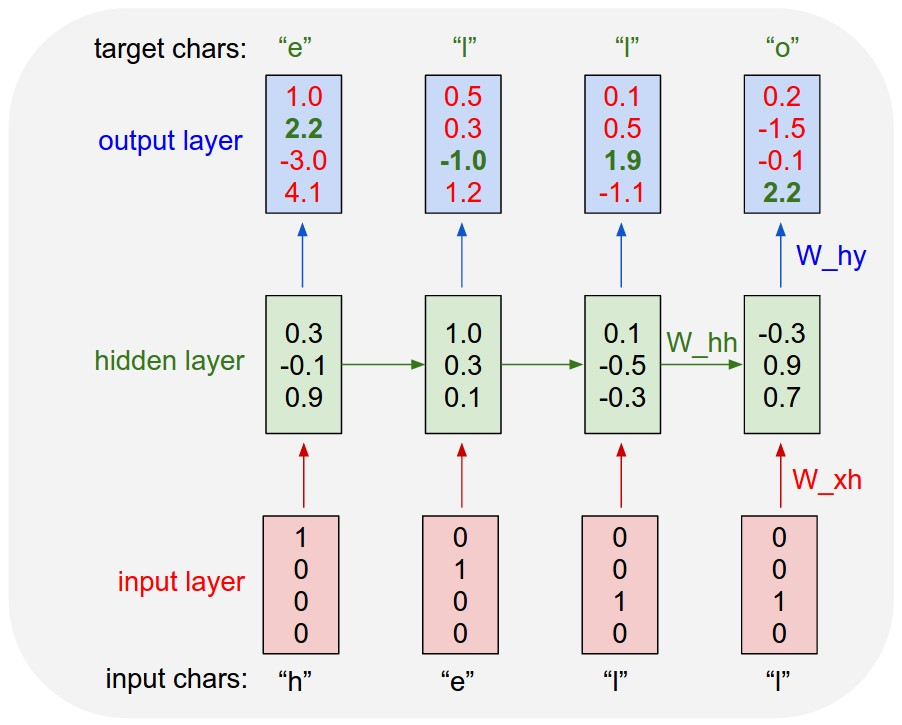

In [10]:
class CharRNN(nn.Module):
  def __init__(self, seq_len:int, embed_dim:int, vocab_size:int, n_layers:int = 1):
    super().__init__()
    self.seq_len = seq_len
    self.embed_dim = embed_dim
    self.vocab_size = vocab_size
    self.n_layers = n_layers
    self.embedding = nn.Embedding(vocab_size, embed_dim)
    self.gru = nn.GRU(input_size=embed_dim, hidden_size=embed_dim, num_layers=n_layers)
    self.fc1 = nn.Linear(embed_dim, vocab_size)

  def forward(self, x:torch.Tensor, hidden:Tuple[torch.Tensor, torch.Tensor]):
    # seq_len needs to be 1 for this to work
    # Shape: (1, seq_len) -> (1, seq_len, embed_dim) -> (1, 1, embed_dim)
    x = self.embedding(x).view(1, 1, -1)
    # Shape: (1, 1, embed_dim), (1, 1, embed_dim) -> (1, 1, embed_dim), (1, 1, embed_dim)
    x, hidden = self.gru(x, hidden)
    # Shape: (1, 1, embed_dim) -> (1, embed_dim) -> (1, vocab_size)
    x = self.fc1(x[0])
    # Return (1, vocab_size), (1, 1, embed_dim)
    return x, hidden

  def init_hidden(self, device=None):
    if device is None:
      device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    hidden_state = torch.zeros(1, 1, self.embed_dim).to(device)
    return hidden_state

In [11]:
validate = False

if validate:
    batch_size = 1
    n_layers = 1
    seq_len = 500
    embed_dim = 200
    vocab_size = 100

    x_test = torch.ones(1, dtype=torch.long).unsqueeze(0)
    print(f"The input shape is: {x_test.shape}")

    embedding = nn.Embedding(vocab_size, embed_dim)
    x_test2 = embedding(x_test)
    print(f"The embedded input shape is: {x_test2.shape}")

    # Initialize hidden state
    hidden = torch.zeros(n_layers, batch_size, embed_dim)
    print(f"The hidden state shape is: {hidden.shape}")

    # Input reshape
    x_test3 = x_test2.view(1, 1, -1)
    print(f"The reshape size is: {x_test3.shape}")

    gru = nn.GRU(input_size=embed_dim, hidden_size=embed_dim, num_layers=n_layers)
    x_test4, hidden2 = gru(x_test3, hidden)
    print(f"The output shape is: {x_test4.shape}")
    print(f"The hidden state shape is: {hidden2.shape}")

    # reshape again:
    x_test5 = x_test4[0]

    fc1 = nn.Linear(embed_dim, vocab_size)
    x_test6 = fc1(x_test5)
    print(f"The logits shape is: {x_test6.shape}")

    # Initialize model
    test_model = CharRNN(seq_len=seq_len, embed_dim=embed_dim, vocab_size=vocab_size, n_layers=n_layers).to('cpu')
    test_hidden_state = test_model.init_hidden(batch_size=1).to('cpu')
    test_logits, test_hidden = test_model(x_test, test_hidden_state)
    print(f"The logits shape is: {test_logits.shape}")
    print(f"The hidden state shape is: {test_hidden.shape}")

## Training the model

In [12]:
def train_rnn(model: nn.Module, text:str, seq_len:int, tokenizer:Tokenizer, optimizer: optim.Optimizer, criterion: nn.Module, device: torch.device):
  model.train().to(device)
  loss = 0
  x, y = get_random_batch(text, seq_len)
  x = tokenizer.tokenize(x)
  y = tokenizer.tokenize(y)
  x, y = x.to(device), y.to(device)
  hidden_state = model.init_hidden().to(device)
  optimizer.zero_grad()
  for char_num in range(len(x)):
    input_ids = x[char_num].unsqueeze(0)
    labels = y[char_num].unsqueeze(0)
    logits, hidden_state = model(input_ids, hidden_state)
    loss += criterion(logits, labels)
  loss.backward()
  optimizer.step()
  return loss.detach().item() / len(x)

In [13]:
def sample_outputs(output, temperature):
  """Takes in a vector of unnormalized probability weights and samples a character from the distribution"""
  return torch.multinomial(torch.exp(output) / temperature, 1)

def generate(model:CharRNN, tokenizer:Tokenizer, device: torch.device, primer:str='A', max_seq_len:int=100, temperature:float=0.8):
    model.eval().to(device)
    prediction = primer
    input_seq = tokenizer.tokenize(primer).to(device)

    # Initialize hidden state
    hidden_state = model.init_hidden()
    hidden_state.detach().to(device)
    
    with torch.no_grad():
      # Process the initial input sequence
      for i in range(len(primer) - 1):
          _, hidden_state = model(input_seq[i], hidden_state)
      input_token = input_seq[-1]

      # Generate the rest of the sequence
      for _ in range(max_seq_len - len(primer)):
        output, hidden_state = model(input_token, hidden_state)
        sampled_character = sample_outputs(output.view(-1), temperature)
        char_choice = tokenizer.detokenize(sampled_character)
        input_token = tokenizer.tokenize(char_choice).to(device)
        prediction += char_choice
    return prediction

In [14]:
# Lists to keep track of loss and generate plot
train_loss = []

# Training Hyperparameters
n_epochs = 1800
print_every = 100
seq_len = chunk_len
embed_dim = 200
vocab_size = vocab_size
n_layers = 1
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# instantiate model, loss function and optimizer
model = CharRNN(seq_len=seq_len, embed_dim=embed_dim, vocab_size=vocab_size, n_layers=n_layers).to(device)
critierion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [15]:
# Training Loop
for epoch in tqdm(range(n_epochs), desc='Training Progress'):
  epoch_train_loss = train_rnn(
    model=model, 
    text=text_clean,
    seq_len=seq_len,
    tokenizer=tokenizer,
    optimizer=optimizer, 
    criterion=critierion, 
    device=device,
    )
  train_loss.append(epoch_train_loss)
  if epoch % print_every == 0:
    print(f'[{epoch+1}/{n_epochs}] Train loss: {epoch_train_loss:.4f} \n')
    print(
      generate(
        model=model, 
        tokenizer=tokenizer, 
        device=device, 
        primer='Wh', 
        max_seq_len=100, 
        temperature=0.8,
        ),
        '\n',
      )

Training Progress:   0%|          | 1/1800 [00:00<07:54,  3.79it/s]

[1/1800] Train loss: 4.6209 

ijOm,X[	vmk#nT?m].BvL!?SQ\	>TgKE;H)%>BuI}
][{Zp 



Training Progress:   6%|▌         | 102/1800 [00:10<03:18,  8.55it/s]

[101/1800] Train loss: 1.9763 

Whe Cianterld the Suntvin in Thi Suns aril theor 20004r the Sonsing Chand anrl, beanonily lear Win t 



Training Progress:  11%|█         | 202/1800 [00:22<03:15,  8.19it/s]

[201/1800] Train loss: 1.1800 

Wh93o Howere ford iohns guary Bave (NBA Alssenter the 200405, altionsiptsipe thy onn aB chavise acqu 



Training Progress:  17%|█▋        | 302/1800 [00:33<02:59,  8.36it/s]

[301/1800] Train loss: 0.6078 

Whe play fold am Dkna.Thes contentiled, attiatit of for their head wouled acfalion. Johnson, and aft 



Training Progress:  22%|██▏       | 402/1800 [00:44<02:52,  8.09it/s]

[401/1800] Train loss: 0.5218 

Whe secamp Arandar Davisin. However theas an early in 1993 NBA hsowned in record. However, the team  



Training Progress:  28%|██▊       | 502/1800 [00:55<02:32,  8.50it/s]

[501/1800] Train loss: 0.2365 

Where sevan hes at the 1990s, and entemecderidom in medicould Werence-tis cont them their Johnson, i 



Training Progress:  33%|███▎      | 602/1800 [01:06<02:10,  9.16it/s]

[601/1800] Train loss: 0.1312 

Whest upsets in NBA hisecord tion to Conference a chmedaing of Kevin Johnson in (NBAF), as an expans 



Training Progress:  39%|███▉      | 702/1800 [01:16<02:02,  8.95it/s]

[701/1800] Train loss: 0.1437 

Whestpphaletred into an team, and their early yeacquisecutive appearancoring team, and entered into  



Training Progress:  45%|████▍     | 802/1800 [01:27<02:00,  8.32it/s]

[801/1800] Train loss: 0.1271 

Wh-ses and Amar'e Stoudemire, and entered into another rebuild. Two more teams to and after trartner 



Training Progress:  50%|█████     | 902/1800 [01:38<01:49,  8.19it/s]

[901/1800] Train loss: 0.0699 

Wh Marion, and until the acquisition of Kevin Johnson in 1988. The Suns in the Nationowned worldwide 



Training Progress:  56%|█████▌    | 1002/1800 [01:49<01:33,  8.55it/s]

[1001/1800] Train loss: 0.0675 

Whed to be one of the biggest upsets in NBA history. However, after failing to capture a championshi 



Training Progress:  61%|██████    | 1102/1800 [01:59<01:19,  8.73it/s]

[1101/1800] Train loss: 0.0751 

Whed to Pacinision of Kevin Johnson in 1988. Under Wajerly Steve Nash, and immediately returned into 



Training Progress:  67%|██████▋   | 1202/1800 [02:10<01:12,  8.30it/s]

[1201/1800] Train loss: 0.0622 

Whise onl team in their division not based in Carley Steve Nash, and immediately returned into playo 



Training Progress:  72%|███████▏  | 1302/1800 [02:21<00:57,  8.65it/s]

[1301/1800] Train loss: 0.0506 

Whalter failing to capture a championship, the Suns would rebuild around Walter Davis for a champion 



Training Progress:  78%|███████▊  | 1402/1800 [02:32<00:46,  8.48it/s]

[1401/1800] Train loss: 0.0537 

Whise record in what is considered to be one of the biggest upsets in NBA history. However, after fa 



Training Progress:  83%|████████▎ | 1502/1800 [02:43<00:34,  8.52it/s]

[1501/1800] Train loss: 0.0412 

Whisto playoff contention. With Nash, Shawn Marion, and AmaPhione home games at the Phoenoned in the 



Training Progress:  89%|████████▉ | 1602/1800 [02:53<00:22,  8.70it/s]

[1601/1800] Train loss: 0.0651 

Whest were shrouded in member owen of Kevin Johnson in 1993 NBA Finals. However, the team would agai 



Training Progress:  95%|█████████▍| 1702/1800 [03:04<00:11,  8.79it/s]

[1701/1800] Train loss: 0.0667 

Whest winning percentage, and have the second higest winning percentag of any teampionship, the Suns 



Training Progress: 100%|██████████| 1800/1800 [03:15<00:00,  9.23it/s]


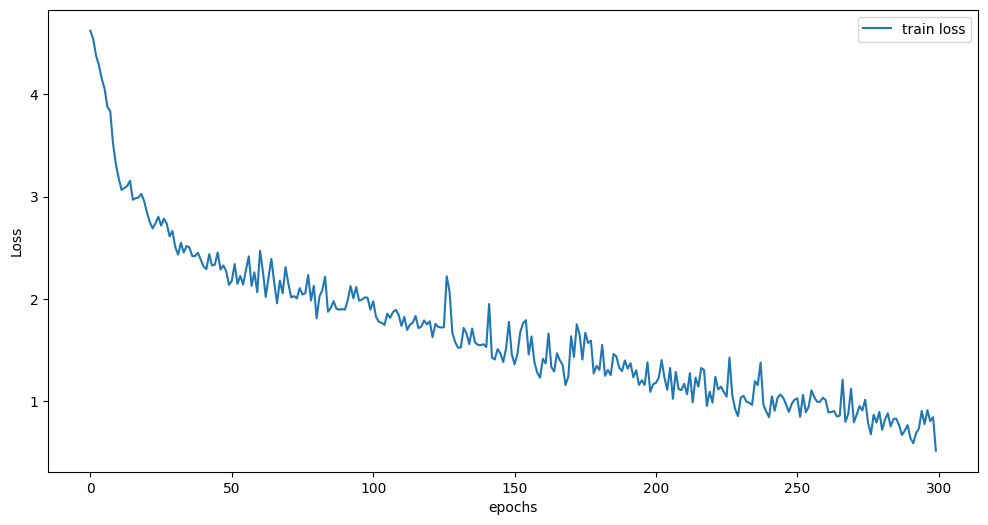

In [16]:
# Plot the training loss
fig, ax1 = plt.subplots(1, figsize=(12, 6), sharex=True)
ax1.plot(train_loss[0:300], label="train loss")
ax1.set_ylabel("Loss")
ax1.set_xlabel("epochs")
ax1.legend()

## Inference

In [17]:
start_strings = ["Th", " wh", " he", " I ", " ca", " We", " lo", " ra"]
for primer in start_strings:
  print(generate(model=model, tokenizer=tokenizer, device=device, primer=primer, max_seq_len=100, temperature=0.8), '\n')

The Suns are the only team in their division not based in California. The Suns play team in their di 

 what is considered to be one of the biggest upsets in NBA history. However, after failinal Associat 

 head coach Mike D'Antoni, the Suns became renowned worldwide for their quick, dynamic offense, whic 

 I mediocrity until the early part of the 2000s. In 2004, the Suns reacquired Steve Nash, and immedi 

 capture a championship, the Suns would rebuild around beald rebuild around Walter Davis for a major 

 Western Conference Pacific Division. The Suns are the only team in their division not based in Cali 

 long-term guard Dick Van Arsdale and center Alvan Adams with Paul Westphal, the Suns reached the pl 

 ravin fail to win a championship, and entered into another period of mediocrity until the early par 

